In [11]:
import re
import itertools
from pathlib import Path
import scipy
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
data_path = Path('../data/mSM63_09-Aug-2018.mat')
data = scipy.io.loadmat(data_path)
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Vm', 'zeromeanVc', 'U', 'R', 'betas', 'lambdas', 'cMap', 'cMovie', 'regLabels', 'regIdx', 'rejIdx', 'regZeroFrames'])

`data['Vm']` contains wide-field imaging time-series, `data['zeromeanVC']` probably is some scaled version of the same data.

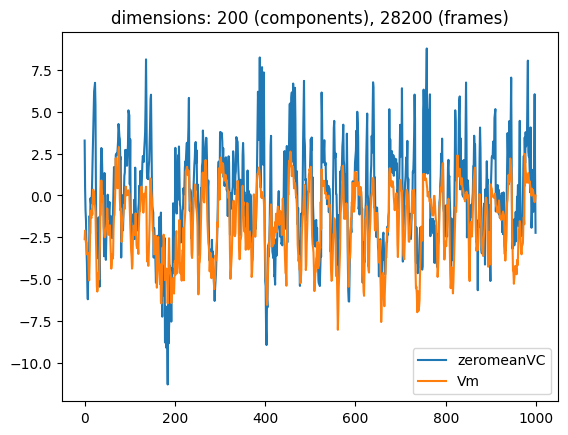

In [3]:
plt.title(f"dimensions: {data['Vm'].shape[0]} (components), {data['Vm'].shape[1]} (frames)")
plt.plot(data['zeromeanVc'][0, :1000], label="zeromeanVC")
plt.plot(data['Vm'][0, :1000], label="Vm")
plt.legend()

Each components is a weighted combination of pixels, weights are stored in `data["U"]`

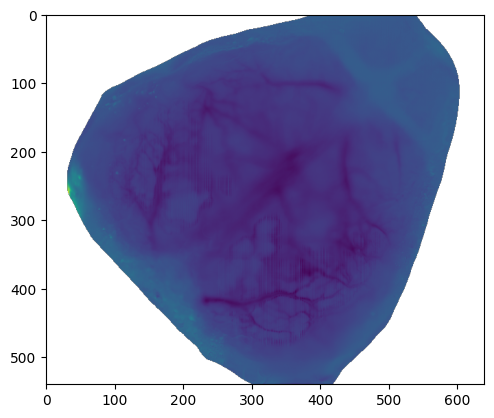

In [4]:
plt.imshow(data["U"][:, :, 0])

`data['R']` contains the design matrix.

Text(0.5, 1.0, 'dimensions: 28200 (frames), 2435 (time-lagged features)')

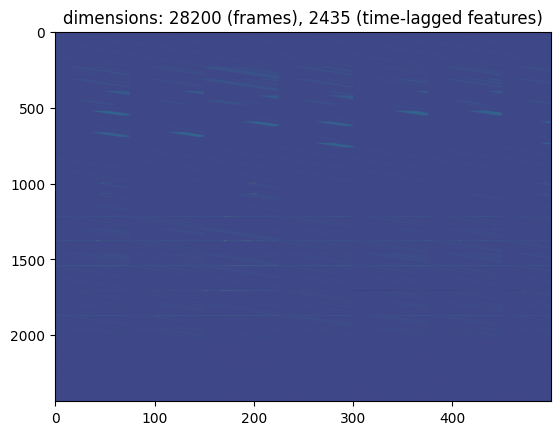

In [5]:
plt.imshow(data['R'][:500].T, aspect="auto")
plt.title(f'dimensions: {data["R"].shape[0]} (frames), {data["R"].shape[1]} (time-lagged features)')

Different regressors are stored in `data["regLabels"]` and `data["regIdx"]` maps the regressors to the design matrix

In [6]:
data["regLabels"].shape, data["regIdx"].shape, np.unique(data["regIdx"]).size

((1, 43), (1, 2435), 43)

data `["lambdas"]` (probably) contains the best $\lambda$ value for every component.

In [7]:
data["betas"].shape, data["lambdas"].shape

((1, 10), (1, 200))

(array([ 8., 16., 38., 52., 41., 20., 11.,  5.,  5.,  4.]),
 array([ 2058.02661133,  3716.08859863,  5374.15058594,  7032.21257324,
         8690.27456055, 10348.33654785, 12006.39853516, 13664.46052246,
        15322.52250977, 16980.58449707, 18638.64648438]),
 <BarContainer object of 10 artists>)

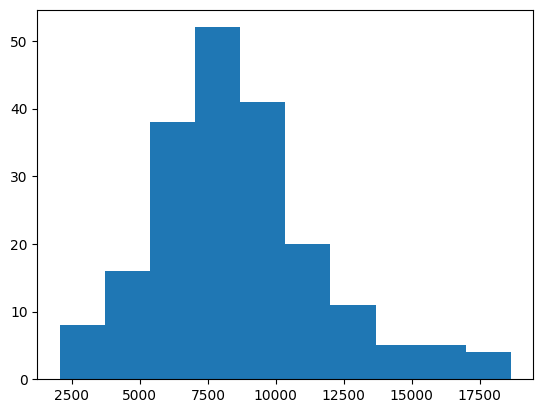

In [8]:
plt.hist(data["lambdas"][0])

Code from [regbench repo](https://github.com/msokolet/regbench/blob/main/regbench.ipynb): the design matrix is converted to a pandas df with labels.

In [ ]:
reg_labels = [label[0] for label in data['regLabels'][0] ]
reg_labels = [re.sub(r'(?<!^)(?=[A-Z])', '_', label).lower() \
            for label in reg_labels] # Convert to snake case
reg_idx = np.array(data['regIdx'])-1 # -1 to convert to Python indexing
design_df_columns = list(itertools.chain.from_iterable([[reg_label]*\
                        len(np.where(reg_idx == reg_id)[0]) \
                        for reg_id, reg_label in enumerate(reg_labels)]))
design_df = pd.DataFrame(data = data["R"], columns = design_df_columns)
design_df

In [58]:
len(design_df_columns), len(reg_idx)

(2435, 1)

What is this?

In [27]:
data["cMovie"].shape, data["cMap"].shape

((224640, 75), (224640, 1))

The model weights are contained in `data["betas"]` there are 10 (probably CV folds) arrays shaped 2435 x 200

In [ ]:
data["betas"].shape, data["betas"][0][0].shape

((1, 10), (2435, 200))

Average across cross-validation folds

In [55]:
beta = np.stack(data["betas"].flatten()).mean(axis=0)
beta.shape

(2435, 200)

Plot weights for 1 regressor

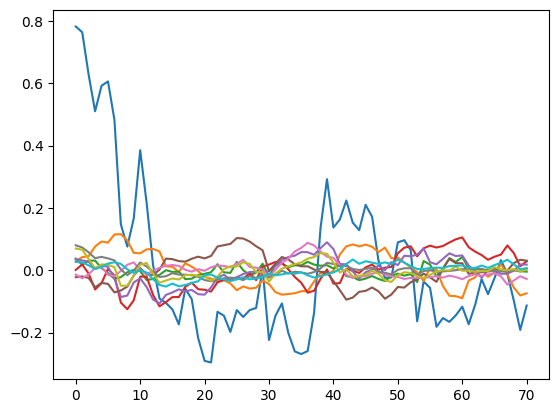

In [57]:
feature = 1
mask = data["regIdx"] == feature
plt.plot(beta[mask.flatten(), 0:10]);